In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import division
import pandas as pd

In [11]:

def loss(y, y_hat):
    # cross entropy
    tot = y * np.log(y_hat)
    return  -tot.sum()

def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

def relu(x):
    return np.maximum(x,0)

def relu_derivative(x):
    return np.where(x>0, 1, 0)

def softmax(z):
    return np.exp(z)/(np.sum(np.exp(z),axis=1))[:,np.newaxis]

def yhat(x, W, b, v, c):
    # returns model prediction 
    h = relu(np.dot(x,W) + b)
    y = sigmoid(np.dot(h,v) + c)
    return y

def binary_xent_residual(y, y_hat):
    return (y/y_hat - (1-y)/(1-y_hat))

def pack_params(param_vec):
    w_11, w_12, w_21, w_22,b_1, b_2,v_11, v_12, v_13, v_21, v_22, v_23, c_1, c_2, c_3 = param_vec
    W = np.array([[w_11,w_12],[w_21,w_22]])
    b = np.array([b_1, b_2])
    v = np.array([[v_11, v_12, v_13],[v_21, v_22, v_23]])
    c = np.array([c_1, c_2, c_3])
    return((W, b, v, c))
    
def unpack_params(W,b,v,c):
    w_11, w_12, w_21, w_22 = W[0,0], W[0,1], W[1,0], W[1,1]
    b_1, b_2 = b[0], b[1]
    v_11, v_12, v_13, v_21, v_22, v_23 = v[0,0], v[0,1], v[0,2], v[1,0], v[1,1], v[1,2]
    c_1, c_2, c_3 = c[0], c[1], c[2]
    return np.array([w_11, w_12, w_21, w_22,b_1, b_2,v_11, v_12, v_13, v_21, v_22, v_23, c_1, c_2, c_3])

In [24]:
def forward(X,parameters):
    # Unpacking parameters    
    W,b1,V,b2 = parameters
    
    # Forward pass
    a1 = X.dot(W) + b1
    H = relu(a1)
    a2 = H.dot(V) + b2
    Y_hat = softmax(a2)
    return Y_hat

In [25]:
W = np.random.randn(4).reshape((2,2))
b = np.random.randn(2)
v = np.random.randn(6).reshape((2,3))
c = np.random.randn(3)

In [26]:
forward(x[0:5,:], (W,b,v,c))

array([[ 0.62061614,  0.05913535,  0.32024851],
       [ 0.35546818,  0.0334609 ,  0.61107092],
       [ 0.59938964,  0.06197975,  0.33863061],
       [ 0.50888101,  0.04485298,  0.44626601],
       [ 0.23318032,  0.02487214,  0.74194754]])

In [5]:
def grad_f(param_vec, x, y):
    
    W, b, v, c = pack_params(param_vec)
    
    a1 = x.dot(W) + b
    H = relu(a1)
    a2 = H.dot(v) + c
    y_hat = softmax(a2)
    
    d_v = H.T.dot((y_hat - y))
    d_c = (y_hat - y).sum(axis=0)
    d_W = x.T.dot(((y_hat - y).dot(v.T) * (H > 0))) 
    d_b = ((y_hat - y).dot(v.T) * (H > 0)).sum(axis=0)
    
    param_vec = unpack_params(d_W, d_b, d_v, d_c)
    return np.array(param_vec)

In [6]:
def grad_descent(x, y,  iterations=10, learning_rate=1e-2):
    point = np.random.uniform(-.1,.1,size=15).astype("float128")
    trajectory = [point]
    losses = [loss(y, yhat(x, *pack_params(point)))]
    
    for i in range(iterations):
        grad = grad_f(point, x, y)
        point = point - learning_rate * grad
        trajectory.append(point)
        losses.append(loss(y, yhat(x, *pack_params(point))))
    return (np.array(trajectory), losses)

## Gaussian Mixture

In [7]:
def gen_gmm_data(n = 999, plot=False):
    # Fixing seed for repeatability
    np.random.seed(123)
    
    # Parameters of a normal distribuion
    mean_1 = [0, 2] ; mean_2 = [2, -2] ; mean_3 = [-2, -2]
    mean = [mean_1, mean_2, mean_3] ; cov = [[1, 0], [0, 1]]  
    
    # Setting up the class probabilities
    n_samples = n
    pr_class_1 = pr_class_2 = pr_class_3 = 1/3.0
    n_class = (n_samples * np.array([pr_class_1,pr_class_2, pr_class_3])).astype(int)
  
    # Generate sample data
    for i in range(3):
        x1,x2 = np.random.multivariate_normal(mean[i], cov, n_class[i]).T
        if (i==0):
            xs = np.array([x1,x2])
            cl = np.array([n_class[i]*[i]])
        else: 
            xs_new = np.array([x1,x2])
            cl_new = np.array([n_class[i]*[i]])
            xs = np.concatenate((xs, xs_new), axis = 1)
            cl = np.concatenate((cl, cl_new), axis = 1)
            
        # One hot encoding classes
    y = pd.Series(cl[0].tolist())
    y = pd.get_dummies(y).as_matrix() 

    # Normalizing data (prevents overflow errors)     
    mu = xs.mean(axis = 1)
    std = xs.std(axis = 1)
    xs = (xs.T - mu) / std
    
    return xs, y, cl

In [8]:
x,y,cl = gen_gmm_data(500)

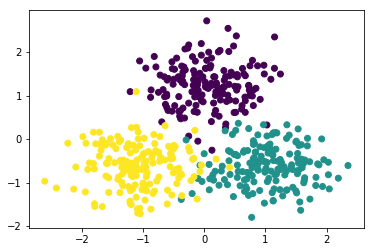

In [9]:
plt.scatter(x[:,0], x[:,1], c=cl)

In [12]:
traj, losses = grad_descent(x, y, iterations=50,learning_rate=1e-2)

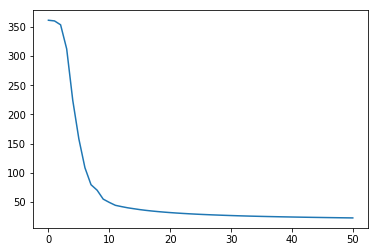

In [27]:
plt.plot(losses)

In [49]:
pred_probs = forward(x,pack_params(traj[-1]))

In [66]:
# accuracy
sum((np.argmax(pred_probs, axis=1) == cl)[0,:]) / cl.shape[1]

0.96586345381526106